In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ai-201-b-ese-aiml-a/sample_submission.csv
/kaggle/input/ai-201-b-ese-aiml-a/train.csv
/kaggle/input/ai-201-b-ese-aiml-a/test.csv


In [2]:

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [4]:
# ================= LOAD DATA =================
train = pd.read_csv("/kaggle/input/ai-201-b-ese-aiml-a/train.csv")
test  = pd.read_csv("/kaggle/input/ai-201-b-ese-aiml-a/test.csv")

test_ids = test["id"]

In [5]:
# ================= DATA CLEANING =================
train.fillna(train.median(numeric_only=True), inplace=True)
test.fillna(test.median(numeric_only=True), inplace=True)

for col in train.select_dtypes(include="object"):
    train[col].fillna(train[col].mode()[0], inplace=True)
    if col in test.columns:
        test[col].fillna(test[col].mode()[0], inplace=True)

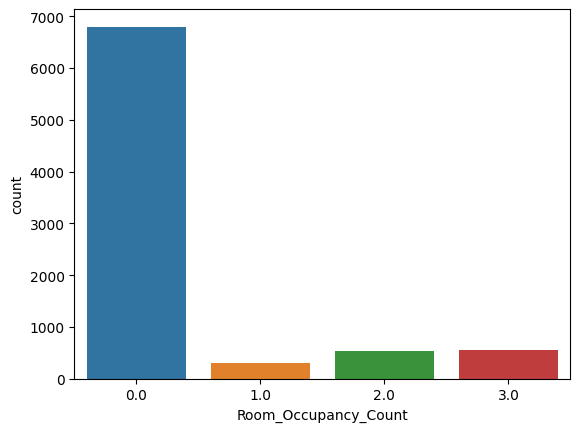

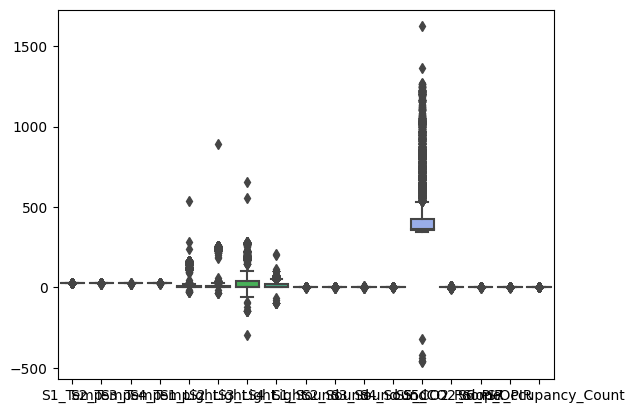

In [7]:
# EDA
sns.countplot(x="Room_Occupancy_Count", data=train)
plt.show()

sns.boxplot(data=train.select_dtypes(include=np.number))
plt.show()

In [8]:
y = train["Room_Occupancy_Count"]
X = train.drop(columns=["Room_Occupancy_Count","id"], errors="ignore")
test = test.drop(columns=["id"], errors="ignore")

# ================= ENCODING FEATURES =================
cat_cols = X.select_dtypes(include="object").columns
oe = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
X[cat_cols] = oe.fit_transform(X[cat_cols])
test[cat_cols] = oe.transform(test[cat_cols])

In [9]:
# $================= ENCODE TARGET =================
le = LabelEncoder()
y_enc = le.fit_transform(y)

In [10]:
# ================= ALIGN =================
X, test = X.align(test, axis=1, fill_value=0)

In [11]:
# ================= SCALING =================
scaler = StandardScaler()
X = scaler.fit_transform(X)
test = scaler.transform(test)

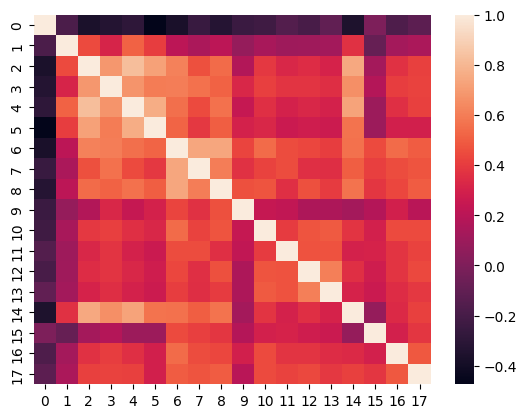

In [12]:
# ================= CORRELATION =================
sns.heatmap(pd.DataFrame(X).corr())
plt.show()

In [13]:
# ================= TRAIN =================
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y_enc, test_size=0.2, stratify=y_enc, random_state=42
)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_tr, y_tr)

RandomForestClassifier(random_state=42)

Accuracy: 0.9811090798293723
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1359
           1       0.86      0.97      0.91        63
           2       0.91      0.99      0.95       108
           3       0.93      0.99      0.96       111

    accuracy                           0.98      1641
   macro avg       0.93      0.98      0.95      1641
weighted avg       0.98      0.98      0.98      1641



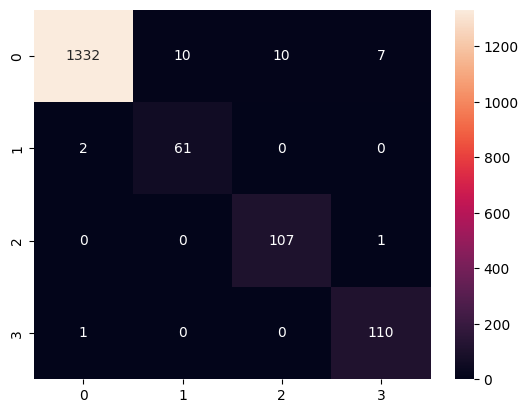

In [14]:
# ================= EVALUATION =================
pred = rf.predict(X_val)
print("Accuracy:", accuracy_score(y_val, pred))
print(classification_report(y_val, pred))

sns.heatmap(confusion_matrix(y_val, pred), annot=True, fmt="d")
plt.show()

In [15]:
# ================= TUNING =================
grid = GridSearchCV(rf, {"n_estimators":[100,200]}, cv=3)
grid.fit(X_tr, y_tr)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'n_estimators': [100, 200]})

In [17]:
# ================= TEST PREDICTION =================
test_pred = grid.best_estimator_.predict(test)
test_pred = le.inverse_transform(test_pred)


In [19]:
# ================= SUBMISSION =================
pd.DataFrame({
    "id": test_ids,
    "Status": test_pred
}).to_csv("Anushka.csv", index=False)